In [1]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [2]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import os
from mediapipe.framework.formats import landmark_pb2
import shutil
import math
import matplotlib.pyplot as plt

In [ ]:
# Eliminar directorio "frames" para reiniciar proceso
frames_dir = "/content/frames"
shutil.rmtree(frames_dir)

In [3]:
# Inicializar url del video
video_url = "/content/persona-corriendo.mp4"

# Inicializar listas para almacenar los ángulos
left_hip_angles = []
left_knee_angles = []
left_ankle_angles = []

right_hip_angles = []
right_knee_angles = []
right_ankle_angles = []

# Función para calcular el ángulo entre dos vectores dados 3 puntos
def calculate_angle(a, b, c):
    # a, b, c son los puntos (landmarks) correspondientes a la articulación
    # Convertir puntos en vectores
    ab = [b.x - a.x, b.y - a.y, b.z - a.z]  # Vector AB
    bc = [c.x - b.x, c.y - b.y, c.z - b.z]  # Vector BC

    # Producto punto de AB y BC
    dot_product = sum([ab[i] * bc[i] for i in range(3)])

    # Magnitudes de AB y BC
    magnitude_ab = math.sqrt(sum([ab[i] ** 2 for i in range(3)]))
    magnitude_bc = math.sqrt(sum([bc[i] ** 2 for i in range(3)]))

    # Evitar divisiones por cero
    if magnitude_ab == 0 or magnitude_bc == 0:
        return None

    # Calcular el ángulo en radianes
    angle_radians = math.acos(dot_product / (magnitude_ab * magnitude_bc))

    # Convertir el ángulo a grados
    angle_degrees = math.degrees(angle_radians)

    return angle_degrees

# Función para obtener las coordenadas y ángulos de las articulaciones de la pierna
def get_leg_angles(detection_result):
    if not detection_result.pose_landmarks:
        return None

    landmarks = detection_result.pose_landmarks.landmark

    # Para la pierna izquierda
    left_hip = landmarks[23]     # Cadera izquierda
    left_knee = landmarks[25]    # Rodilla izquierda
    left_ankle = landmarks[27]   # Tobillo izquierdo
    left_shoulder = landmarks[11]  # Hombro izquierdo
    left_foot_index = landmarks[31]  # Índice del pie izquierdo

    # Para la pierna derecha
    right_hip = landmarks[24]    # Cadera derecha
    right_knee = landmarks[26]   # Rodilla derecha
    right_ankle = landmarks[28]  # Tobillo derecho
    right_shoulder = landmarks[12]  # Hombro derecho
    right_foot_index = landmarks[32]  # Índice del pie derecho

    # Calcular ángulos de la pierna izquierda
    left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    left_ankle_angle = calculate_angle(left_knee, left_ankle, left_foot_index)  # Usando el pie como referencia

    # Calcular ángulos de la pierna derecha
    right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
    right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
    right_ankle_angle = calculate_angle(right_knee, right_ankle, right_foot_index)

    return {
        "left_leg": {
            "hip_angle": left_hip_angle,
            "knee_angle": left_knee_angle,
            "ankle_angle": left_ankle_angle
        },
        "right_leg": {
            "hip_angle": right_hip_angle,
            "knee_angle": right_knee_angle,
            "ankle_angle": right_ankle_angle
        }
    }

def get_leg_coordinates(detection_result):
    if not detection_result.pose_landmarks:
        print("No se detectaron landmarks.")
        return None

    # Obtener los landmarks
    landmarks = detection_result.pose_landmarks.landmark

    # Obtener coordenadas para la pierna izquierda
    left_hip = landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP.value]
    left_knee = landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE.value]
    left_ankle = landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE.value]

    # Obtener coordenadas para la pierna derecha
    right_hip = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HIP.value]
    right_knee = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_KNEE.value]
    right_ankle = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE.value]

    # Crear diccionario con las coordenadas
    leg_coordinates = {
        'left_hip': (left_hip.x, left_hip.y),
        'left_knee': (left_knee.x, left_knee.y),
        'left_ankle': (left_ankle.x, left_ankle.y),
        'right_hip': (right_hip.x, right_hip.y),
        'right_knee': (right_knee.x, right_knee.y),
        'right_ankle': (right_ankle.x, right_ankle.y)
    }

    return leg_coordinates

# Función para dibujar los puntos de referencia en la imagen.
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Verificar si se detectaron landmarks
    if pose_landmarks:
      # Dibujar los puntos de referencia de la pose.
      mp.solutions.drawing_utils.draw_landmarks(
          annotated_image,
          pose_landmarks,
          mp.solutions.pose.POSE_CONNECTIONS,
          mp.solutions.drawing_styles.get_default_pose_landmarks_style()
      )
    else:
      print(f"No se detectaron landmarks en el fotograma")

    return annotated_image

# Función para dividir el video en fotogramas.
def split_video_into_frames(video_path):
  # Crear una carpeta para guardar los fotogramas si no existe
  os.makedirs("frames", exist_ok=True)

  #Intentar abrir el video
  capture = cv2.VideoCapture(video_path)

  if not capture.isOpened():
    print(f"Error: No se pudo abrir el video {video_path}")
    return
  else:
    print(f"El video se abrió con exito")

  frame_count = 0 # Inicializamos el contador de frames
  pose = mp.solutions.pose.Pose() # Inicializamos la deteccion de poses

  while capture.isOpened():
    ret, frame = capture.read()

    # Detiene el bucle al finalizar el video
    if not ret:
      print(f"Fin del video")
      break

    if frame is None:
      print(f"Fotograma {frame_count} no es valido (None)")
      continue

    # Convertir BGR a RGB (OpenCV usa BGR y MediaPipe RGB)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)# Realizar deteccion de pose
    leg_coords = get_leg_coordinates(results) #Obtener coordenadas de las piernas
    if leg_coords:
      print(f"Coordenadas de las piernas en fotograma {frame_count}: {leg_coords}")

    annotated_frame = draw_landmarks_on_image(rgb_frame, results) # Dibujar landmarks en frame
    annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

    # Guardar cada fotograma como una imagen en la carpeta 'frames'
    frame_path = f"frames/frame_{frame_count:03d}.jpg"
    success = cv2.imwrite(frame_path, annotated_frame_bgr)

    # Obtener y mostrar los ángulos de la pierna
    leg_angles = get_leg_angles(results)
    if leg_angles:
      print(f"Frame {frame_count}:")
      print(f"Left leg angles: Hip = {leg_angles['left_leg']['hip_angle']}, "
            f"Knee = {leg_angles['left_leg']['knee_angle']}, "
            f"Ankle = {leg_angles['left_leg']['ankle_angle']}")
      print(f"Right leg angles: Hip = {leg_angles['right_leg']['hip_angle']}, "
            f"Knee = {leg_angles['right_leg']['knee_angle']}, "
            f"Ankle = {leg_angles['right_leg']['ankle_angle']}")

    if leg_angles:
      left_hip_angles.append(leg_angles['left_leg']['hip_angle'])
      left_knee_angles.append(leg_angles['left_leg']['knee_angle'])
      left_ankle_angles.append(leg_angles['left_leg']['ankle_angle'])

      right_hip_angles.append(leg_angles['right_leg']['hip_angle'])
      right_knee_angles.append(leg_angles['right_leg']['knee_angle'])
      right_ankle_angles.append(leg_angles['right_leg']['ankle_angle'])

    if not success:
      print(f"Error: No se pudo guardar el fotograma {frame_count}")
      break
    else:
      frame_count += 1

  capture.release()
  pose.close()
  print(f"Video dividido en {frame_count} fotogramas.")
  plot_angles()

# Función para graficar los ángulos
def plot_angles():
    frames = list(range(len(left_hip_angles)))  # Número de fotogramas (eje x)

    plt.figure(figsize=(12, 8))

    # Graficar los ángulos de la pierna izquierda
    plt.subplot(2, 1, 1)
    plt.plot(frames, left_hip_angles, label='Cadera Izquierda', color='blue')
    plt.plot(frames, left_knee_angles, label='Rodilla Izquierda', color='orange')
    plt.plot(frames, left_ankle_angles, label='Tobillo Izquierdo', color='green')
    plt.title('Ángulos de las Articulaciones (Pierna Izquierda)')
    plt.xlabel('Fotogramas')
    plt.ylabel('Ángulo (grados)')
    plt.legend()
    plt.grid()

    # Graficar los ángulos de la pierna derecha
    plt.subplot(2, 1, 2)
    plt.plot(frames, right_hip_angles, label='Cadera Derecha', color='blue')
    plt.plot(frames, right_knee_angles, label='Rodilla Derecha', color='orange')
    plt.plot(frames, right_ankle_angles, label='Tobillo Derecho', color='green')
    plt.title('Ángulos de las Articulaciones (Pierna Derecha)')
    plt.xlabel('Fotogramas')
    plt.ylabel('Ángulo (grados)')
    plt.legend()
    plt.grid()

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

def start():
  split_video_into_frames(video_url)

El video se abrió con exito


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Coordenadas de las piernas en fotograma 0: {'left_hip': (0.49983081221580505, 0.4850216209888458), 'left_knee': (0.5141976475715637, 0.6434639692306519), 'left_ankle': (0.4165814518928528, 0.5795542597770691), 'right_hip': (0.5052938461303711, 0.4887339770793915), 'right_knee': (0.5609443783760071, 0.6695654988288879), 'right_ankle': (0.5378289222717285, 0.8536900281906128)}
Frame 0:
Left leg angles: Hip = 33.015801799568024, Knee = 79.90875177002826, Ankle = 86.94038410956468
Right leg angles: Hip = 32.50913747074359, Knee = 33.95784660633398, Ankle = 88.24319487693968
Coordenadas de las piernas en fotograma 1: {'left_hip': (0.4989246428012848, 0.48506999015808105), 'left_knee': (0.5027421712875366, 0.642928421497345), 'left_ankle': (0.4156244397163391, 0.5794759392738342), 'right_hip': (0.5050408244132996, 0.48875024914741516), 'right_knee': (0.5588904619216919, 0.6697917580604553), 'right_ankle': (0.5340549945831299, 0.8538981080055237)}
Frame 1:
Left leg angles: Hip = 29.5173629737

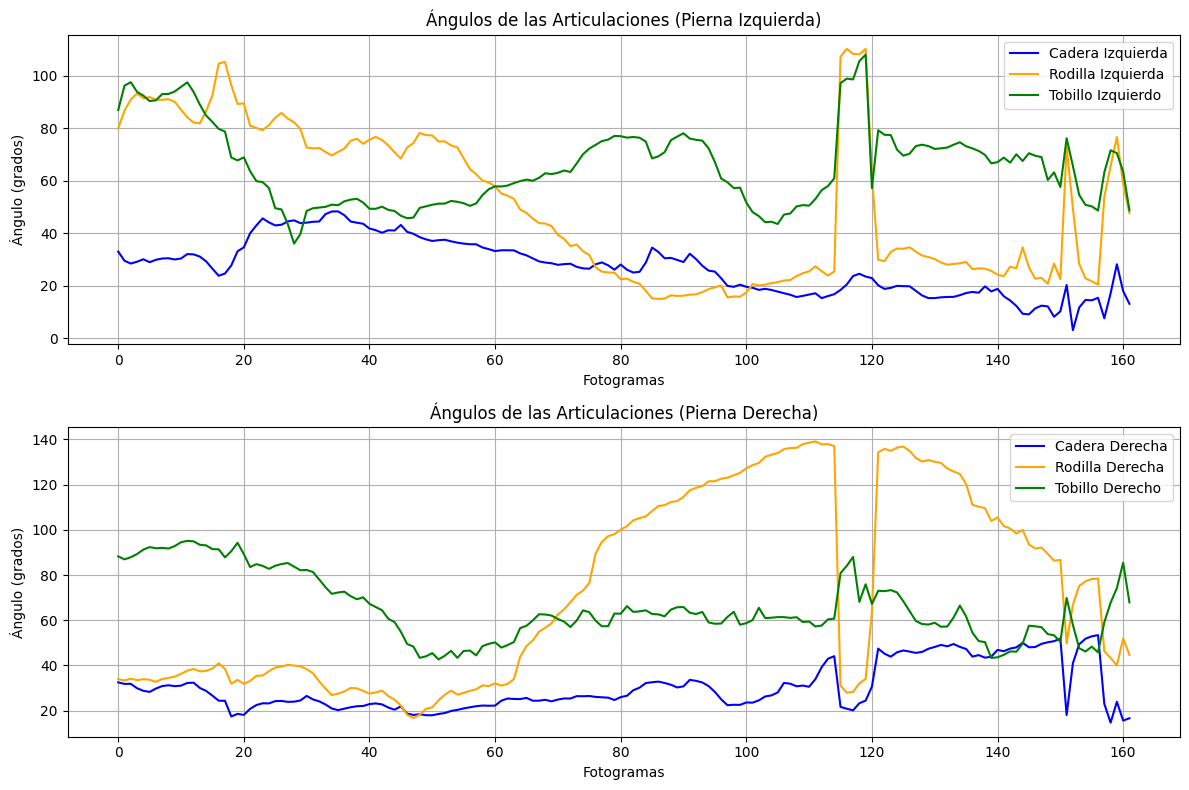

In [4]:
start()